In [84]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import make_classification, make_regression
from scipy.stats import spearmanr
from xgboost import XGBClassifier, XGBRegressor

# import the path of the project
sys.path.append(os.path.abspath("src"))

from preprocess.FeatureSplitter import CorrelationSplitter, ImportanceSplitter
from preprocess.FeatureEvaluator import CorrelationEvaluator, ImportanceEvaluator
from dataset.WideDataset import WideDataset
from dataset.SatelliteDataset import SatelliteDataset

#auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Summarize a correlation matrix calculated between two parties (X_i and X_j)
# The shape of corr is (X_i.shape[1], X_j.shape[1])

def pcor_eigen(corr):
    """Summarize the correlation matrix corr"""
    assert corr.shape[0] == corr.shape[1]   # eigenvalues are only defined for square matrices
    eigen_values = np.linalg.eigvals(corr)
    score = np.std(eigen_values)
    return score

def pcor_singular(corr):
    """Summarize the correlation matrix corr"""
    singular_values = np.linalg.svd(corr)[1]
    score = np.std(singular_values)
    return score

print(pcor_eigen(np.ones((10, 10))))
print(pcor_eigen(np.eye(10)))
print(pcor_singular(np.ones((10, 10))))
print(pcor_singular(np.eye(10)))

3.0
0.0
2.999999999999999
0.0


In [35]:
# Generate two binary classification datasets with correlated features and a target
def test_correlation_by_moving_features(n_informative, n_features1, n_features2, pcor_func, save_path=None, label='Pcor'):

    # set a larger font size for plots
    plt.rcParams.update({'font.size': 16})

    assert n_features1 <= n_features2
    assert n_informative <= n_features1 and n_informative <= n_features2
    n_features_on_party = [n_features1, n_features2]
    n_features = n_features1 + n_features2
    X1, y1 = make_classification(n_samples=10000, n_features=n_features1, n_informative=n_informative,
                                 n_redundant=n_features1 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=0, shuffle=True)
    X2, y2 = make_classification(n_samples=10000, n_features=n_features2, n_informative=n_informative,
                                 n_redundant=n_features2 - n_informative,
                                 n_repeated=0, n_classes=2, random_state=1, shuffle=True)
    X = np.concatenate([X1, X2], axis=1)
    corr = spearmanr(X).correlation

    X1_ids = np.arange(n_features)[:n_features1]
    X2_ids = np.arange(n_features)[n_features1:]
    n_X1s = np.arange(n_features1 + 1)
    pcor1s = []
    pcor2s = []
    pcor12s = []
    for n_X1 in n_X1s:
        assert n_X1 <= n_features1
        X1_ids_1 = X1_ids[:n_X1]
        X2_ids_1 = X2_ids[:n_features1-n_X1]
        ids_1 = np.concatenate([X1_ids_1, X2_ids_1])
        X1_ids_2 = X1_ids[n_X1:]
        X2_ids_2 = X2_ids[n_features1-n_X1:]
        ids_2 = np.concatenate([X1_ids_2, X2_ids_2])

        corr1 = corr[ids_1, :][:, ids_1]
        corr2 = corr[ids_2, :][:, ids_2]
        corr_12 = corr[ids_1, :][:, ids_2]

        # initialize a new correlation matrix with an identity matrix
        corr_masked = np.zeros(corr.shape)
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]
        corr_masked[np.ix_(ids_1, ids_2)] = corr[np.ix_(ids_1, ids_2)]

        pcor1 = pcor_func(corr1)
        pcor2 = pcor_func(corr2)
        pcor12 = pcor_func(corr_12)
        # print(f"n_X1: {n_X1}, pcor1: {pcor1:.4f}, pcor2: {pcor2:.4f}, pcor12: {pcor12:.8f}")
        pcor1s.append(pcor1)
        pcor2s.append(pcor2)
        pcor12s.append(pcor12)


    # plot the trend of pcor1, pcor2, and pcor12 w.r.t. n_X1
    ax = plt.gca()
    ax.invert_xaxis()
    fig = plt.gcf()
    plt.xlabel("Party $P_1$: number of features from $X_1$")
    plt.ylabel(f"Correlation Index ({label})")
    ax.plot(n_X1s, pcor1s, label=f"{label}1-1", marker="o")
    ax.plot(n_X1s, pcor2s, label=f"{label}2-2", marker="^")
    ax.plot(n_X1s, pcor12s, label=f"{label}1-2", marker="x")
    # add an x-axis to show the number of informative features from X2

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax.set_xticks(n_X1s)
    ax.set_xticklabels(n_X1s)
    ax2.set_xticks(n_X1s)
    ax2.set_xticklabels(n_features1 - n_X1s)
    ax2.set_xlabel("Party $P_2$: number of features from $X_1$")

    # plt.title(f"(Party 1: {n_features1} features, Party 2: {n_features2} features)\n(X1: {n_features1} features, X2: {n_features2} features)")

    ax.legend()
    plt.show()

    if save_path is not None:
        fig.savefig(save_path)
    plt.close()


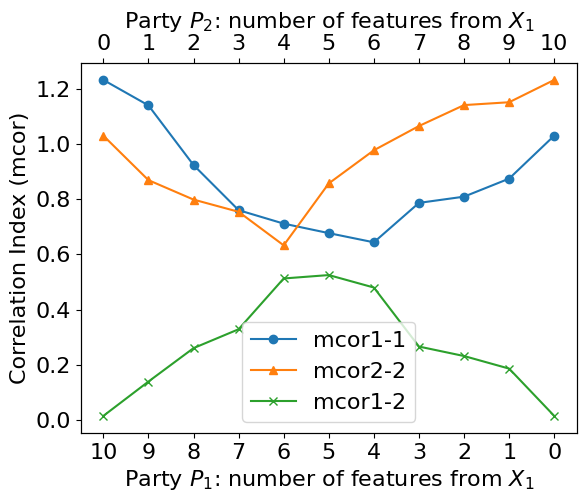

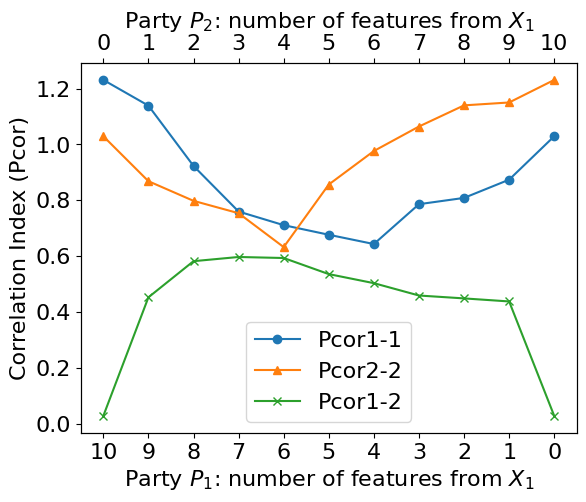

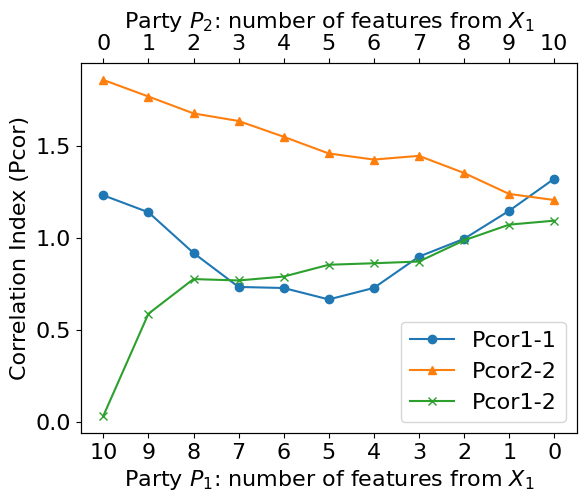

In [37]:
# test two functions
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_eigen,
                                    save_path="fig/pcor-eigen-10-10.png", label='mcor')
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=10, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-10.png")
test_correlation_by_moving_features(n_informative=6, n_features1=10, n_features2=20, pcor_func=pcor_singular,
                                    save_path="fig/pcor-singular-10-20.png")

In [26]:
# generate three independent datasets
X1 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=0, shuffle=True)[0]
X2 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=1, shuffle=True)[0]
X3 = make_classification(n_samples=10000, n_features=10, n_informative=3, n_redundant=7, random_state=2, shuffle=True)[0]

# concatenate them to a global dataset
X = np.concatenate([X1, X2, X3], axis=1)
np.random.shuffle(X.T)

# original three parties
corr_evaluator_original = CorrelationEvaluator(gpu_id=0)
score_original = corr_evaluator_original.fit_evaluate([X1, X2, X3])
corr_evaluator_original.visualize("fig/pcor-original.png", value=score_original)

# fit the correlation splitter to get the lowest and highest correlation scores
corr_splitter = CorrelationSplitter(num_parties=3, evaluator=CorrelationEvaluator(gpu_id=0), gpu_id=0)
corr_splitter.fit(X, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)


CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.03s
CorrelationEvaluator uses cuda:0
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.8094769997 |  0.7348143458
     2 |     1800 |  0.8019562121 |  0.7081426382
     3 |     2600 |  0.7971003982 |  0.7081426382
     4 |     3400 |  0.7968741019 |  0.6834173203
     5 |     4200 |  0.7950092761 |  0.6765739024
     6 |     5000 |  0.7928937828 |  0.6765739024
     7 |     5800 |  0.7918364580 |  0.6765739024
     8 |     6600 |  0.7898010842 |  0.6765739024
     9 |     7400 |  0.7885040436 |  0.6221222083
    10 |     8200 |  0.7872393962 |  0.6179156800
    11 |     9000 |  0.7855027169 |  0.6179156800
    12 |     9800 |  0.7853230850 |  0.6179156800
    13 |    10600 |  0.7814802435 |  0.6179156800
    14 |    11400 |  0.7804818783 |  0.6179156800
    15 |    12200 |  0.7790039512 |  0.5882597466
    16 |    13000 |  0.7768721824 |  

In [27]:
# split the correlation matrix with different beta
Xs_00 = corr_splitter.split(X, beta=0.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_00 = CorrelationEvaluator(gpu_id=0)
score_00 = corr_evaluator_00.fit_evaluate(Xs_00)
corr_evaluator_00.visualize("fig/pcor-split-beta0.0.png", value=score_00, fontsize=28)

Xs_05 = corr_splitter.split(X, beta=0.5, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_05 = CorrelationEvaluator(gpu_id=0)
score_05 = corr_evaluator_05.fit_evaluate(Xs_05)
corr_evaluator_05.visualize("fig/pcor-split-beta0.5.png", value=score_05, fontsize=28)

X_10 = corr_splitter.split(X, beta=1.0, n_elites=200, n_offsprings=700, n_mutants=100, verbose=True)
corr_evaluator_10 = CorrelationEvaluator(gpu_id=0)
score_10 = corr_evaluator_10.fit_evaluate(X_10)
corr_evaluator_10.visualize("fig/pcor-split-beta1.0.png", value=score_10, fontsize=28)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.7767228214 |  0.6806237424
     2 |     1800 |  0.7679596693 |  0.6806237424
     3 |     2600 |  0.7643292229 |  0.6485753184
     4 |     3400 |  0.7635121106 |  0.6485753184
     5 |     4200 |  0.7602736262 |  0.6485753184
     6 |     5000 |  0.7588425980 |  0.6485753184
     7 |     5800 |  0.7582783826 |  0.6485753184
     8 |     6600 |  0.7561867962 |  0.6402281746
     9 |     7400 |  0.7525851977 |  0.6402281746
    10 |     8200 |  0.7506494522 |  0.6366805757
    11 |     9000 |  0.7494127356 |  0.6056104824
    12 |     9800 |  0.7471773719 |  0.5961941754
    13 |    10600 |  0.7416076899 |  0.5264275695
    14 |    11400 |  0.7371783958 |  0.5264275695
    15 |    12200 |  0.7316584721 |  0.4754698202
    16 |    13000 |  0.7250294456 |  0.4754698202
    17 |    13800 |  0.7151888357 |  0.4754698202
    18 |    14600 |  0.6997284828 |  0.3332143078
    19 |    15400 |  0.6882489218 |  0.2904579081


In [24]:
# correlation score of randomly shuffled the features
X_shuffle = X.copy()
np.random.shuffle(X_shuffle.T)
Xs_shuffle = np.split(X_shuffle, 3, axis=1)
corr_evaluator_shuffle = CorrelationEvaluator(gpu_id=0)
score_shuffle = corr_evaluator_shuffle.fit_evaluate(Xs_shuffle)
corr_evaluator_shuffle.visualize("fig/pcor-shuffle.png", value=score_shuffle, fontsize=28)

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.03s


# Start evaluating real datasets

In [44]:
# Load Wide dataset
image_path = "data/real/nus-wide/uncompressed/images"
tag_path = "data/real/nus-wide/uncompressed/tags"
label_path = "data/real/nus-wide/uncompressed/labels"

train_test_wide_dataset = WideDataset.from_source(image_path, tag_path, label_path)
train_wide_dataset = train_test_wide_dataset.train
test_wide_dataset = train_test_wide_dataset.test
wide_Xs = []
for dataset in train_wide_dataset.local_datasets:
    print(dataset.X.shape)
    wide_Xs.append(dataset.X)

Loading CH...
Loading CORR...
Loading EDH...
Loading WT...
Loading CM55...
Loading tags...
Loading labels...
(161789, 65)
(161789, 145)
(161789, 74)
(161789, 129)
(161789, 226)
(161789, 1001)


In [219]:
# Load Vehicle dataset
vehicle_X, vehicle_y = load_svmlight_file("data/real/vehicle/processed/vehicle.libsvm")
vehicle_X = vehicle_X.toarray()
vehicle_y = vehicle_y.astype('int') - 1
vehicle_Xs = [vehicle_X[:, :50], vehicle_X[:, 50:]]

print(vehicle_Xs[0].shape)
print(vehicle_Xs[1].shape)

(78823, 50)
(78823, 50)


In [64]:
# Load satellite dataset
satellite_data = SatelliteDataset.from_pickle("data/real/satellite/cache/", n_jobs=8)
satellite_Xs = []
for dataset in satellite_data.local_datasets:
    satellite_Xs.append(dataset.X)
print(f"Size of Xs: {[X.shape for X in satellite_Xs]}")

# random sample some features for evaluation
satellite_n_features = 100
print(f"Random sample {satellite_n_features} features for evaluation")
satellite_Xs_sample_flatten = []
for X in satellite_Xs:
    X_flatten = X.reshape(X.shape[0], -1)
    X_sample = X_flatten[:, np.random.permutation(X_flatten.shape[1])[:satellite_n_features]]
    satellite_Xs_sample_flatten.append(X_sample)
print(f"Size of Xs: {[X.shape for X in satellite_Xs_sample_flatten]}")

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.47s/it]


Size of Xs: [torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158]), torch.Size([3142, 13, 158, 158])]
Random sample 100 features for evaluation
Size of Xs: [torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3142, 100]), torch.Size([3

In [67]:
# evaluate Icor for wide dataset
corr_evaluator_wide = CorrelationEvaluator(gpu_id=0)
wide_Xs = wide_Xs[:5]   # remove the tag features
icor_wide = corr_evaluator_wide.fit_evaluate(wide_Xs)
corr_evaluator_wide.visualize("fig/pcor-wide.png", value=icor_wide, fontsize=24)
print(f"icor for wide dataset: {icor_wide}")

# evaluate beta for wide dataset
wide_X = np.concatenate(wide_Xs, axis=1)
corr_splitter_wide = CorrelationSplitter(num_parties=5, evaluator=corr_evaluator_wide, gpu_id=0)
corr_splitter_wide.fit(wide_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=100, verbose=True)
beta_wide = corr_splitter_wide.evaluate_beta(icor_wide)

print(f"beta for wide dataset: {beta_wide}, Icor: {icor_wide} in range [{corr_splitter_wide.min_mcor}, {corr_splitter_wide.max_mcor}]")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 10.21s
icor for wide dataset: 1.6242226600646972
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  2.3938623066 |  2.3768684626
     2 |     1800 |  2.3919266732 |  2.3768684626
     3 |     2600 |  2.3908279408 |  2.3714181662
     4 |     3400 |  2.3898262185 |  2.3691941023
     5 |     4200 |  2.3889798086 |  2.3691941023
     6 |     5000 |  2.3880145855 |  2.3630794048
     7 |     5800 |  2.3869659449 |  2.3620074987
     8 |     6600 |  2.3859795729 |  2.3599693298
     9 |     7400 |  2.3849104720 |  2.3568766594
    10 |     8200 |  2.3840252414 |  2.3568766594
    11 |     9000 |  2.3827084359 |  2.3561859846
    12 |     9800 |  2.3812313551 |  2.3501911402
    13 |    10600 |  2.3792465975 |  2.3484003305
    14 |    11400 |  2.3767489044 |  2.3484003305
    15 |    12200 |  2.3748737650 |  2.3373238564
    16 |    13000 |  2.3718

The score 1.6242226600646972 is out of range [1.833816921710968, 2.4033166408538817].


In [59]:
# evaluate Icor for vehicle dataset
corr_evaluator_vehicle = CorrelationEvaluator(gpu_id=0)
icor_vehicle = corr_evaluator_vehicle.fit_evaluate(vehicle_Xs)
corr_evaluator_vehicle.visualize("fig/pcor-vehicle.png", value=icor_vehicle, fontsize=28)
print(f"icor for vehicle dataset: {icor_vehicle}")

# evaluate beta for vehicle dataset
vehicle_X = np.concatenate(vehicle_Xs, axis=1)
corr_splitter_vehicle = CorrelationSplitter(num_parties=2, evaluator=corr_evaluator_vehicle, gpu_id=0)
corr_splitter_vehicle.fit(vehicle_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=50, verbose=True)
beta_vehicle = corr_splitter_vehicle.evaluate_beta(icor_vehicle)

print(f"beta for vehicle dataset: {beta_vehicle}, Icor: {icor_vehicle} in range [{corr_splitter_vehicle.min_mcor}, {corr_splitter_vehicle.max_mcor}]")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.79s
icor for vehicle dataset: 0.3144468069076538
Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  1.9528337682 |  1.7872939110
     2 |     1800 |  1.9387080113 |  1.7471835613
     3 |     2600 |  1.9279161421 |  1.7471835613
     4 |     3400 |  1.9171551555 |  1.5844467878
     5 |     4200 |  1.9011503512 |  1.5534389019
     6 |     5000 |  1.8893663378 |  1.5254532099
     7 |     5800 |  1.8792687224 |  1.5254532099
     8 |     6600 |  1.8592856774 |  1.5254532099
     9 |     7400 |  1.8403456762 |  1.4020684958
    10 |     8200 |  1.8139901160 |  1.3983650208
    11 |     9000 |  1.7820950514 |  1.3532844782
    12 |     9800 |  1.7383805887 |  1.2721011639
    13 |    10600 |  1.7016272686 |  1.1526664495
    14 |    11400 |  1.6618976501 |  1.1389803886
    15 |    12200 |  1.6170020858 |  1.1187165976
    16 |    13000 |  1.57

In [82]:
# evaluate Icor for satellite dataset and plot
n_satellite_features = 10
satellite_Xs_sample_flatten_less_features = [X[:, :n_satellite_features] for X in satellite_Xs_sample_flatten]

corr_evaluator_satellite = CorrelationEvaluator(gpu_id=0)
icor_satellite = corr_evaluator_satellite.fit_evaluate(satellite_Xs_sample_flatten_less_features)
corr_evaluator_satellite.visualize("fig/pcor-satellite.png", value=icor_satellite, fontsize=16, title_size=28)
print(f"icor for satellite dataset: {icor_satellite}")

CorrelationEvaluator uses cuda:0
Correlation calculation time: 0.05s
icor for satellite dataset: 0.8916697144508362


In [78]:
# evaluate beta for satellite dataset
satellite_X = np.concatenate(satellite_Xs_sample_flatten_less_features, axis=1)
corr_splitter_satellite = CorrelationSplitter(num_parties=16, evaluator=corr_evaluator_satellite, gpu_id=0)
corr_splitter_satellite.fit(satellite_X, n_elites=200, n_offsprings=700, n_mutants=100, n_gen=50, verbose=True)

Calculating the min mcor of the overall correlation score...
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |     1000 |  0.9189268910 |  0.9146896064
     2 |     1800 |  0.9183828263 |  0.9141957685
     3 |     2600 |  0.9180957733 |  0.9141957685
     4 |     3400 |  0.9178973052 |  0.9137429987
     5 |     4200 |  0.9177931988 |  0.9137429987
     6 |     5000 |  0.9177510225 |  0.9133762111
     7 |     5800 |  0.9176124424 |  0.9129516035
     8 |     6600 |  0.9176293195 |  0.9129516035
     9 |     7400 |  0.9175627177 |  0.9121924847
    10 |     8200 |  0.9173885935 |  0.9121924847
    11 |     9000 |  0.9174622167 |  0.9121924847
    12 |     9800 |  0.9174231154 |  0.9121924847
    13 |    10600 |  0.9174423796 |  0.9121924847
    14 |    11400 |  0.9173606429 |  0.9121924847
    15 |    12200 |  0.9173129181 |  0.9121924847
    16 |    13000 |  0.9173443187 |  0.9121924847
    17 |    13800 |  0.9173136448 |  0.9121924847
    18 |    14600 |  0.9172902653 |  0.

TypeError: CorrelationSplitter.evaluate_beta() got an unexpected keyword argument 'tol'

In [79]:
beta_satellite = corr_splitter_satellite.evaluate_beta(icor_satellite)
print(f"beta for satellite dataset: {beta_satellite}, Icor: {icor_satellite} in range [{corr_splitter_satellite.min_mcor}, {corr_splitter_satellite.max_mcor}]")

beta for satellite dataset: -0.7747665486215084, Icor: 0.8916697144508362 in range [0.9069718579451244, 0.9267225086688995]


The score 0.8916697144508362 is out of range [0.9069718579451244, 0.9267225086688995].


# In the following, we will evaluate the importance $\alpha$ of each dataset

In [249]:
# train a model for wide dataset to evaluate Shapley value
wide_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="binary:logistic", tree_method="gpu_hist")
wide_model.fit(wide_X, train_wide_dataset.local_datasets[0].y, verbose=True)

# evaluate importance of wide dataset
imp_evaluator_wide = ImportanceEvaluator(sample_rate=0.01)
imp_wide_scores = imp_evaluator_wide.evaluate(wide_Xs, wide_model.predict, max_evals=1500)
print(f"Importance of wide dataset: {imp_wide_scores}")



Permutation explainer:   1%|▌                                               | 21/1617 [00:00<?, ?it/s]

Permutation explainer:   1%|▌                                       | 23/1617 [00:10<06:28,  4.10it/s]

Permutation explainer:   1%|▌                                       | 24/1617 [00:11<08:23,  3.16it/s]

Permutation explainer:   2%|▌                                       | 25/1617 [00:11<09:49,  2.70it/s]

Permutation explainer:   2%|▋                                       | 26/1617 [00:12<11:07,  2.38it/s]

Permutation explainer:   2%|▋                                       | 27/1617 [00:12<12:10,  2.18it/s]

Permutation explainer:   2%|▋                                       | 28/1617 [00:13<14:03,  1.88it/s]

Permutation explainer:   2%|▋                                       | 29/1617 [00:14<14:11,  1.87it/s]

Permutation explainer:   2%|▋                                       | 30/1617 [00:14<14:05,  1.88it/s]

Permutation explainer:   2%|▊                                 

Importance of wide dataset: [0.05766234 0.15584416 0.12672233 0.12286642 0.41504947]


In [250]:
# estimate the alpha of wide dataset
wide_dir_ratio = imp_wide_scores / np.sum(imp_wide_scores)
wide_alpha = corr_splitter_wide.evaluate_alpha(wide_dir_ratio)
print(f"alpha of wide dataset: {wide_alpha}")

alpha of wide dataset: 1.4064229540297244


In [220]:
# train a model for vehicle dataset to evaluate Shapley value
vehicle_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
vehicle_model.fit(vehicle_X, vehicle_y, verbose=True)

# evaluate importance of vehicle dataset
imp_evaluator_vehicle = ImportanceEvaluator(sample_rate=0.001)
imp_vehicle_scores = imp_evaluator_vehicle.evaluate(vehicle_Xs, vehicle_model.predict, max_evals=1500)
print(f"Importance of vehicle dataset: {imp_vehicle_scores}")


Importance of vehicle dataset: [0.45521978 0.71833333]


In [221]:
# estimate the alpha of vehicle dataset
vehicle_alpha = corr_splitter_vehicle.evaluate_alpha(imp_vehicle_scores)
print(f"alpha of vehicle dataset: {vehicle_alpha}")


alpha of vehicle dataset: 9.446930089178933


In [223]:
# train a model for satellite dataset to evaluate Shapley value
satellite_model = XGBClassifier(n_estimators=50, max_depth=6, n_jobs=16, learning_rate=0.1, objective="multi:softmax", tree_method="gpu_hist")
satellite_X_train = np.concatenate(satellite_Xs_sample_flatten, axis=1)
satellite_y_train = satellite_data.local_datasets[0].y
satellite_model.fit(satellite_X_train, satellite_y_train, verbose=True)

# evaluate importance of satellite dataset
imp_evaluator_satellite = ImportanceEvaluator(sample_rate=0.01)
imp_satellite_scores = imp_evaluator_satellite.evaluate(satellite_Xs_sample_flatten, satellite_model.predict, max_evals=3500)
print(f"Importance of satellite dataset: {imp_satellite_scores}")



Permutation explainer:  13%|██████▌                                            | 4/31 [00:00<?, ?it/s]

Permutation explainer:  19%|████████▎                                  | 6/31 [00:15<00:49,  1.96s/it]

Permutation explainer:  23%|█████████▋                                 | 7/31 [00:18<00:56,  2.35s/it]

Permutation explainer:  26%|███████████                                | 8/31 [00:21<01:00,  2.65s/it]

Permutation explainer:  29%|████████████▍                              | 9/31 [00:25<01:03,  2.90s/it]

Permutation explainer:  32%|█████████████▌                            | 10/31 [00:28<01:04,  3.09s/it]

Permutation explainer:  35%|██████████████▉                           | 11/31 [00:32<01:03,  3.15s/it]

Permutation explainer:  39%|████████████████▎                         | 12/31 [00:34<00:58,  3.06s/it]

Permutation explainer:  42%|█████████████████▌                        | 13/31 [00:37<00:55,  3.06s/it]

Permutation explainer:  45%|██████████████████▉               

Importance of satellite dataset: [0.12096774 0.15290323 0.03758065 0.05951613 0.05483871 0.05677419
 0.06387097 0.05693548 0.06048387 0.08306452 0.03451613 0.10903226
 0.06645161 0.07467742 0.04629032 0.0666129 ]


In [225]:
# estimate the alpha of satellite dataset
satellite_alpha = corr_splitter_satellite.evaluate_alpha(imp_satellite_scores)
print(f"alpha of satellite dataset: {satellite_alpha}")

alpha of satellite dataset: 5.102918519556013


# Plot the distribution of $\alpha$ and $\beta$ of each dataset

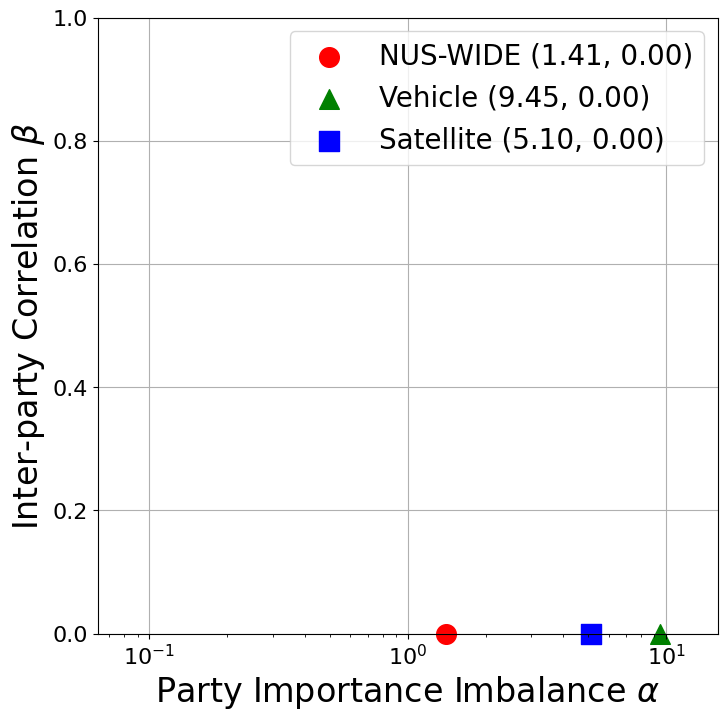

In [283]:
# plot the distribution of alpha and beta in one image, one dimension is importance-alpha, the other is correlation-beta
# each dataset is a point in plot
def round_in_range(x, min_x=0., max_x=1.):
    if x < min_x:
        return min_x
    elif x > max_x:
        return max_x
    else:
        return x

wide_beta_round = round_in_range(beta_wide)
vehicle_beta_round = round_in_range(beta_vehicle)
satellite_beta_round = round_in_range(beta_satellite)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(wide_alpha, wide_beta_round, c="r", marker="o", label=rf"NUS-WIDE ({wide_alpha:.2f}, {wide_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(vehicle_alpha, vehicle_beta_round, c="g", marker="^", label=rf"Vehicle ({vehicle_alpha:.2f}, {vehicle_beta_round:.2f})",
           s=200, clip_on=False)
ax.scatter(satellite_alpha, satellite_beta_round, c="b", marker="s", label=rf"Satellite ({satellite_alpha:.2f}, {satellite_beta_round:.2f})",
           s=200, clip_on=False)
ax.set_xlabel(r"Party Importance Imbalance $\alpha$", fontsize=24)
ax.set_ylabel(r"Inter-party Correlation $\beta$", fontsize=24)
ax.set_xlim([10**-1.2, 10**1.2])
ax.set_ylim([0, 1])
# set xaxis as log scale
ax.set_xscale("log")
ax.legend(fontsize=20)
ax.grid(True)
plt.show()
